# import libraries and data 

In [335]:
#os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import geopy
import mapclassify
from geopy.geocoders import Nominatim
import geocoder
from shapely.geometry import Point, Polygon
import pyrosm
from db import Database

db = Database()



data_folder = '../data/'

# Read in the data
df1 = gpd.read_file(data_folder + 'NYKO_2017_-_nivå_1.geojson')
df3 = gpd.read_file(data_folder + 'NYKO_2017_-_nivå_3.geojson')

connecting to default database ...
connected to db 


## spatial projection
i choose this projectio because is the best for sweden, talk about also others

In [214]:
proj = 'EPSG:32633'

df1 = df1.to_crs(proj) # EPSG:2836
df3 = df3.to_crs(proj)


## spatial operation
now i want only thw city of uppsala and not the county becuse i have data of different levels 
- level 1 just distinguish between the city and the county
- level 3 is more detailed and distinguish between the different districts of the city

i get the centroid of level 3 and i check if this point is inside the city of uppsala, i remove the other points and rename the columns

In [248]:
df3['centroid'] = df3['geometry'].centroid
df3['is_city'] = df3['centroid'].within(df1.loc[0].geometry)
df = df3[df3.is_city]
df = df.rename(columns={'N3Namn17': 'name', 'N3Kod17': 'district_id'}) 


# geocoding 
take name of the university and map

In [97]:
# find university lat and long and project to the right coordinate system


uni_name = "Ångströmlaboratoriet, Uppsala"
location = geocoder.osm(uni_name)
uni_coords = location.latlng
uni = Point(uni_coords[1], uni_coords[0])
uni = gpd.GeoDataFrame({'geometry': uni}, index=[0], crs="EPSG:4326").to_crs(proj)#.geometry[0]



# open street map 
prendere dati bus e supermercato magari altro e mescolarlo con i dati di uppsala, 

In [352]:
from shapely.wkt import loads
from shapely import wkb

results = db.query('SELECT ST_AsBinary(way) FROM planet_osm_polygon WHERE building = \'yes\'')
buildings = {}
for i,  result in enumerate(results):
    buildings[i] = wkb.loads(result[0].hex(), hex=True).wkt # translate binary to shapely geometry

buildings = gpd.GeoDataFrame.from_dict(buildings, orient='index', columns=['geometry'])
buildings['geometry'] = buildings['geometry'].apply(loads)# load the geometry from the wkt
buildings.crs = "EPSG:900913" # set crs to EPSG:900913
buildings = buildings.to_crs(proj)

Executing query: SELECT ST_AsBinary(way) FROM planet_osm_polygon WHERE building = 'yes'
Fetching results...
Got 25186 results


In [227]:
# load osm file from db and project to the right coordinate system

bus_stops = db.get_bus_stops()
supermarkets = db.get_supermarkets()

bus_stops = bus_stops.to_crs(proj)
supermarkets = supermarkets.to_crs(proj)




<AxesSubplot:>

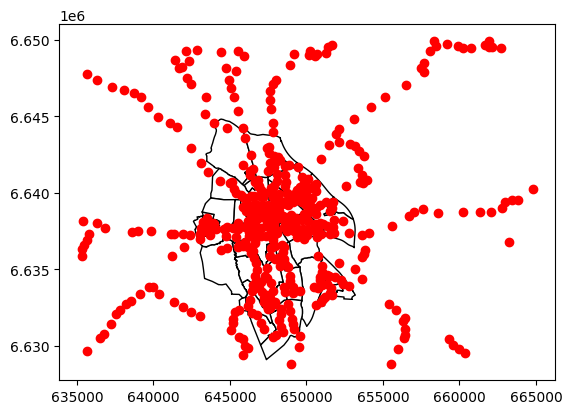

In [228]:
ax = df.plot(color='white', edgecolor='black')
bus_stops.plot(ax=ax, color='red')


In [359]:

    

# add district to buildings
def add_district(df, gdf):
    for i, row in gdf.iterrows():
        district =  df[df.contains(row.geometry)]
        if len(district) > 0:
            district = district.iloc[0]['name']
        else:
            district = None
        gdf.loc[i, 'district'] = district
    return gdf

buildings = add_district(df, buildings)
supermarkets = add_district(df, supermarkets)
bus_stops = add_district(df, bus_stops)


<AxesSubplot:>

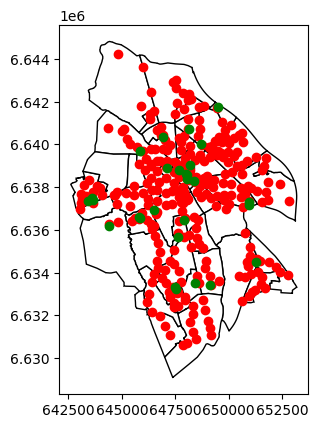

In [285]:
ax = df.plot(color='white', edgecolor='black')
bus_stops.plot(ax=ax, color='red')
supermarkets.plot(ax=ax, color='green')

In [364]:
bus_stops = bus_stops[-bus_stops['district'].isna()]
stop_frequence = bus_stops.value_counts('district').to_frame().reset_index()
stop_frequence.rename(columns={0: 'bus_stop_count'}, inplace=True)

supermarkets = supermarkets[-supermarkets['district'].isna()]
supermarket_frequence = supermarkets.value_counts('district').to_frame().reset_index()
supermarket_frequence.rename(columns={0: 'supermarket_count'}, inplace=True)

buildings = buildings[-buildings['district'].isna()]
building_frequence = buildings.value_counts('district').to_frame().reset_index()
building_frequence.rename(columns={0: 'building_count'}, inplace=True)

In [367]:
df2 = df.merge(stop_frequence, left_on='name', right_on='district')
df2 = df2.merge(supermarket_frequence, left_on='name', right_on='district', how='left')
df2 = df2.merge(building_frequence, left_on='name', right_on='district', how='left')

df2['supermarket_count'] = df2['supermarket_count'].fillna(0)


In [380]:
from folium.plugins import MarkerCluster
centerx = df2.to_crs(epsg = 4326).unary_union.centroid.x
centery = df2.to_crs(epsg = 4326).unary_union.centroid.y

webmapcluster = folium.Map(location=[centery,centerx],zoom_start=12)


marker_cluster = MarkerCluster().add_to(webmapcluster)

buildings_wsg = buildings.to_crs(epsg = 4326)
buildings_wsg['centroid'] = buildings_wsg['geometry'].centroid

for index, building in buildings_wsg.iterrows():
    marker = folium.Marker(location=[building.centroid.y, building.centroid.x])
    marker.add_to(marker_cluster)

webmapcluster

/var/folders/rp/wqtfdr1111xgsfxx0y9x2rjr0000gn/T/ipykernel_44654/4170967973.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings_wsg['centroid'] = buildings_wsg['geometry'].centroid


In [382]:
palette = ['#ffffcc','#a1dab4','#41b6c4','#2c7fb8','#253494']
m = df2.explore(column='building_count',scheme= 'jenkscaspall', legend=True, cmap='Blues')
m

In [383]:
df2['adj_stop_count'] = df2['bus_stop_count'] / df2['building_count']
df2['adj_supermarket_count'] = df2['supermarket_count'] / df2['building_count']

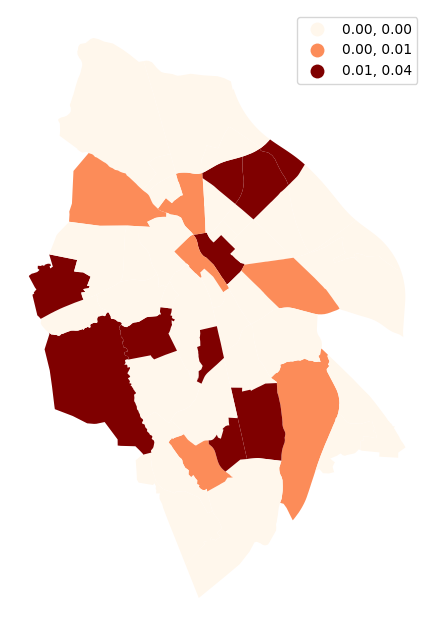

In [397]:
import matplotlib.pyplot as plt
ax = df2.plot(column='adj_supermarket_count', scheme='quantiles', legend=True, cmap='OrRd', figsize=(8,8))
ax.set_axis_off()
plt.show()

# netowrk analysis 
find closest bus stop to the university and the closest supermarket, isocrone  etc 

# trajectory analysis ???

# raster data 

# spatial regression

Durbin model, local and global spilpver